In [15]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import json
import pandas as pd
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

Functions declaration

In [16]:
## -- FUNCTIONS DEFINITION

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new 

In [17]:
# -- Path for netcdf files
out_path = "G:/Shared drives/Amazon_ENSO_work/RESULTS/validation/"
# out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS'


## Open FLUXCOM data
Carbon and Energy Fluxes (RS_METEO) based on WFDEI climatological forcing dataset (https://rda.ucar.edu/datasets/ds314.2/), covering the period 197901 - 201312

GPP is DOWNWARD flux of Carbon (out of atmosphere) \
TER is UPWARD flux of Carbon (into the atmosphere) \
NEP in FLUXCOM represents UPWARD flux of Carbon (into atmosphere) whereas in ESM represents DOWNWARD flux of carbon (out of atmosphere)

In [18]:
data_path = 'D:/Data/Reanalysis/'               

# Carbon Fluxes
file = "nee_wfdei_197901-201312.nc" 
ds_nep_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_nep_flux = ds_nep_flux.isel(lat=slice(None, None, -1))

file = "ter_wfdei_197901-201312.nc" 
ds_ter_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_ter_flux = ds_ter_flux.isel(lat=slice(None, None, -1))

file = "gpp_wfdei_197901-201312.nc" 
ds_gpp_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_gpp_flux = ds_gpp_flux.isel(lat=slice(None, None, -1))
#ds_pr = ds_pr.assign_coords(lat=(ds_pr.lat + 0.5)); 

# Energy Fluxes
file = "h_wfdei_197901-201312.nc" 
ds_h_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_h_flux = ds_h_flux.isel(lat=slice(None, None, -1))

file = "le_wfdei_197901-201312.nc" 
ds_le_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_le_flux = ds_le_flux.isel(lat=slice(None, None, -1))

file = "rn_wfdei_197901-201312.nc" 
ds_rn_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_rn_flux = ds_rn_flux.isel(lat=slice(None, None, -1))


In [19]:
# Convert dataset to dataarray

ds_nep_flux = ds_nep_flux.NEE; ds_ter_flux = ds_ter_flux.TER; ds_gpp_flux = ds_gpp_flux.GPP
ds_h_flux = ds_h_flux.H; ds_le_flux = ds_le_flux.LE; ds_rn_flux = ds_rn_flux.Rn

## Open ERA5 data

Precipitation and Temperature donwloaded from ERA5 reanalyses (0.5x0.5), whereas Soil Moisture and LAI from ERA5-Land reanalyses (0.25x0.25)

In [20]:
data_path = 'D:/Data/Reanalysis/'   

file = "era5_tp_195001-201612_raw_f32.nc" 
ds_pr_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]) #ds_pr = ds_pr.mean(axis=0)
ds_pr_era5 = ds_pr_era5.rename(latitude = "lat", longitude = "lon")
ds_pr_era5 = ds_pr_era5.isel(lat=slice(None, None, -1))

file = "era5_mrso_195001-201812.nc"
ds_mrso_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_mrso_era5 = ds_mrso_era5.rename(latitude = "lat", longitude = "lon")
ds_mrso_era5 = ds_mrso_era5.isel(lat=slice(None, None, -1))

file = "era5_tas_195001-201612_raw_f32.nc"
ds_tas_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_tas_era5 = ds_tas_era5.rename(latitude = "lat", longitude = "lon")
ds_tas_era5 = ds_tas_era5.isel(lat=slice(None, None, -1))


In [21]:
data_path = 'D:/Data/Reanalysis/'   
file = "era5_mrso_195001-201812.nc"
ds_mrso_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_mrso_era5 = ds_mrso_era5.rename(latitude = "lat", longitude = "lon")
ds_mrso_era5 = ds_mrso_era5.isel(lat=slice(None, None, -1))

In [22]:
# Convert dataset to dataarray
ds_pr_era5 = ds_pr_era5.tp; ds_mrso_era5 = ds_mrso_era5.mrso; ds_tas_era5 = ds_tas_era5.t2m

## Open ESM data

In [23]:
data_path = 'D:/Data/analysis/'              
scenario = 'historical'

# Carbon Fluxes
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):               # List of files sorted by name
        content = nc.Dataset(filepath).parent_source_id
        files_list.append(content)

ds_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_nep.append(content)

## -- Correct E3SM dataarray by masking values of 1e+20 over ocean
for i, item in enumerate(files_list):
    if files_list[i] == 'E3SM-1-1-ECA' and var_name == "nep":
        ds_nep[i] = ds_nep[i].where((ds_nep[i]< 5000)&(ds_nep[i]> -5000))   
    elif files_list[i] == 'E3SM-1-1-ECA' and (var_name == "ter" or var_name =="gpp"):
        ds_nep[i] = ds_nep[i].where((ds_nep[i]< 10000))   

esm = []
for filepath in sorted(glob.glob(os.path.join('D:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_nep[i] = ds_nep[i]*-1
        else:
                None

var_name = 'gpp'
ds_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_gpp.append(content)

var_name = 'ter'
ds_ter = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_ter.append(content)

# Energy Fluxes
var_name = 'hfls'
ds_le = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_le.append(content)

var_name = 'rsds'
ds_rn = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_rn.append(content)

# Climatological
var_name = 'pr'
ds_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_pr.append(content)

var_name = 'mrso'
ds_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_mrso.append(content)

var_name = 'tas'
ds_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_tas.append(content)

# Correct values of E3SM
for i,item in enumerate(ds_tas[6]):
    if item.mean(...) < 0:
        print(i)
        ds_tas[6][i] = ds_tas[6][:250].groupby('time.month').mean(dim = "time")[0].values
    else:
       None

## Preprocessing 

### Convert units of reanalysis to match ESMs

In [24]:
# Carbon fluxes convertion
ds_nep_flux = ds_nep_flux * 365 * -1
ds_nep_flux.attrs['units'] = 'gC m-2 y-1'

ds_gpp_flux = ds_gpp_flux * 365
ds_gpp_flux.attrs['units'] = 'gC m-2 y-1'

ds_ter_flux = ds_ter_flux * 365
ds_ter_flux.attrs['units'] = 'gC m-2 y-1' 

# Energy fluxes convertion
ds_h_flux = ds_h_flux * 1/0.0864        # 1J = 1W*s
ds_h_flux.attrs['units'] = 'W m-2'

ds_le_flux = ds_le_flux * 1/0.0864      # 1J = 1W*s
ds_le_flux.attrs['units'] = 'W m-2'

ds_rn_flux = ds_rn_flux * 1/0.0864      # 1J = 1W*s
ds_rn_flux.attrs['units'] = 'W m-2' 

ds_et_flux = ds_le_flux * (1/30) * (1/2.453)
ds_et_flux.attrs['units'] = 'mm month-1'

# Precipitation  & Soil Moisture conversion
ds_pr_era5 = ds_pr_era5 * 1000  # convert meter to mm/day by multiplying with 1000*24/step (step is 24 hrs in this case)
ds_pr_era5 = ds_pr_era5 * ds_pr_era5.time.dt.days_in_month
ds_pr_era5.attrs['units'] = 'mm month-1'

ds_mrso_era5 = ds_mrso_era5 
ds_mrso_era5.attrs['units'] = 'kg m-2'

ds_tas_era5 = ds_tas_era5 - 273.15
ds_tas_era5.attrs['units'] = '°C'

### Regridding to common 1 x 1 grid and select common time period 197901 - 201312

Reanalysis:

In [25]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

# Define Longitude from -180 to 180
ds_nep_flux = lon180(ds_nep_flux); ds_gpp_flux = lon180(ds_gpp_flux); ds_ter_flux = lon180(ds_ter_flux)
ds_le_flux = lon180(ds_le_flux); ds_rn_flux = lon180(ds_rn_flux)
ds_pr_era5 = lon180(ds_pr_era5); ds_tas_era5 = lon180(ds_tas_era5); ds_mrso_era5 = lon180(ds_mrso_era5)

# Select period from 197901 to 201312
ds_nep_flux = ds_nep_flux.sel(time = slice("1979-01", "2013-12")); ds_gpp_flux = ds_gpp_flux.sel(time = slice("1979-01", "2013-12")); ds_ter_flux = ds_ter_flux.sel(time = slice("1979-01", "2013-12"))
ds_le_flux = ds_le_flux.sel(time = slice("1979-01", "2013-12")); ds_rn_flux = ds_rn_flux.sel(time = slice("1979-01", "2013-12"))
ds_pr_era5 = ds_pr_era5.sel(time = slice("1979-01", "2013-12")); ds_tas_era5 = ds_tas_era5.sel(time = slice("1979-01", "2013-12")); ds_mrso_era5 = ds_mrso_era5.sel(time = slice("1979-01", "2013-12"))

# Select lon lat of Amazon basin
ds_nep_flux = ds_nep_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_gpp_flux = ds_gpp_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_ter_flux = ds_ter_flux.sel(lon = slice(-85, -30), lat = slice(-30,15))
ds_le_flux = ds_le_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_rn_flux = ds_rn_flux.sel(lon = slice(-85, -30), lat = slice(-30,15))
ds_pr_era5 = ds_pr_era5.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_tas_era5 = ds_tas_era5.sel(lon = slice(-85, -30), lat = slice(-30,15))

# Regrid ERA5 data to FLUXCOM resolution
ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 15, 1)

regrid_nep_flux = xe.Regridder(ds_nep_flux, ds_out, "bilinear")
regrid_pr_era5 = xe.Regridder(ds_pr_era5, ds_out, "bilinear")
regrid_tas_era5 = xe.Regridder(ds_tas_era5, ds_out, "bilinear")
regrid_mrso_era5 = xe.Regridder(ds_mrso_era5, ds_out, "bilinear")

ds_nep_flux = regrid_nep_flux(ds_nep_flux, keep_attrs=True); ds_gpp_flux = regrid_nep_flux(ds_gpp_flux, keep_attrs=True); ds_ter_flux = regrid_nep_flux(ds_ter_flux, keep_attrs=True)
ds_le_flux = regrid_nep_flux(ds_le_flux, keep_attrs=True); ds_rn_flux = regrid_nep_flux(ds_rn_flux, keep_attrs=True)
ds_pr_era5 = regrid_pr_era5(ds_pr_era5, keep_attrs=True); ds_tas_era5 = regrid_tas_era5(ds_tas_era5, keep_attrs=True); ds_mrso_era5 = regrid_mrso_era5(ds_mrso_era5, keep_attrs=True)


ESMs:

In [26]:
# Define Longitude from -180 to 180
ds_nep = [lon180(a) for a in ds_nep]; ds_gpp = [lon180(a) for a in ds_gpp]; ds_ter = [lon180(a) for a in ds_ter]
ds_le = [lon180(a) for a in ds_le]; ds_rn = [lon180(a) for a in ds_rn]
ds_pr = [lon180(a) for a in ds_pr]; ds_tas = [lon180(a) for a in ds_tas]; ds_mrso = [lon180(a) for a in ds_mrso]

# Select period from 197901 to 201312
ds_nep = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_nep]; ds_gpp = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_gpp]; ds_ter = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_ter]; 
ds_le = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_le]; ds_rn = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_rn]
ds_pr = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_pr]; ds_mrso = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_mrso]; ds_tas = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_tas]

# Select lon lat of Amazon basin
ds_nep = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_nep]; ds_gpp = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_gpp]; ds_ter = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_ter]; 
ds_le = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_le]; ds_rn = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_rn]
ds_pr = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_pr]; ds_mrso = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_mrso]; ds_tas = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_tas]

# Regrid to 1 x 1 
ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 15, 1)

regrid = [xe.Regridder(a, ds_out, "bilinear") for a in ds_nep]

ds_nep = [regr(a, keep_attrs=True) for a,regr in zip(ds_nep,regrid)]; ds_gpp = [regr(a, keep_attrs=True) for a,regr in zip(ds_gpp,regrid)]; ds_ter = [regr(a, keep_attrs=True) for a,regr in zip(ds_ter,regrid)]
ds_le = [regr(a, keep_attrs=True) for a,regr in zip(ds_le,regrid)]; ds_rn = [regr(a, keep_attrs=True) for a,regr in zip(ds_rn,regrid)]
ds_pr = [regr(a, keep_attrs=True) for a,regr in zip(ds_pr,regrid)]; ds_mrso = [regr(a, keep_attrs=True) for a,regr in zip(ds_mrso,regrid)]; ds_tas = [regr(a, keep_attrs=True) for a,regr in zip(ds_tas,regrid)]

## Mediate response of ESM

In [27]:
ds_nep = xr_mean_list(ds_nep, files_list); ds_gpp = xr_mean_list(ds_gpp, files_list); ds_ter = xr_mean_list(ds_ter, files_list)
ds_le = xr_mean_list(ds_le, files_list); ds_rn = xr_mean_list(ds_rn, files_list)
ds_pr = xr_mean_list(ds_pr, files_list); ds_mrso = xr_mean_list(ds_mrso, files_list); ds_tas = xr_mean_list(ds_tas, files_list) 

## Seasonal cycle

pr,tas,mrso

In [28]:
# Compute multi-year monthly mean 
ds_pr_era5_monmean = ds_pr_era5.groupby('time.month').mean(dim = 'time')
ds_tas_era5_monmean = ds_tas_era5.groupby('time.month').mean(dim = 'time')
ds_mrso_era5_monmean = ds_mrso_era5.groupby('time.month').mean(dim = 'time')

ds_pr_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_pr]
# ds_tas_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_tas]
ds_mrso_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_mrso]

# Zonal mean of renalysis and ESM
def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_m.groupby("region").mean(...)
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

ds_pr_era5_amz = zonal_stat(ds_pr_era5_monmean, geodf).sel(region = 1)
ds_pr_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_pr_monmean]

ds_tas_era5_amz = zonal_stat(ds_tas_era5_monmean, geodf).sel(region = 1)
ds_tas_amz1 = [zonal_stat(a, geodf).sel(region = 1) for a in ds_tas]

# Correct for spurious value of temperature on E3SM
jan_mean = ds_tas_amz1[6].sel(time = ds_tas_amz1[6].time.dt.month == 1).where(ds_tas_amz1[6].sel(time = ds_tas_amz1[6].time.dt.month == 1) >= 0).mean()
ds_tas_amz1[6] = xr.where(ds_tas_amz1[6]<0, jan_mean.values, ds_tas_amz1[6])
ds_tas_amz = [a.groupby('time.month').mean(dim = 'time') for a in ds_tas_amz1]

ds_mrso_era5_amz = zonal_stat(ds_mrso_era5_monmean, geodf).sel(region = 1)
ds_mrso_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_mrso_monmean]

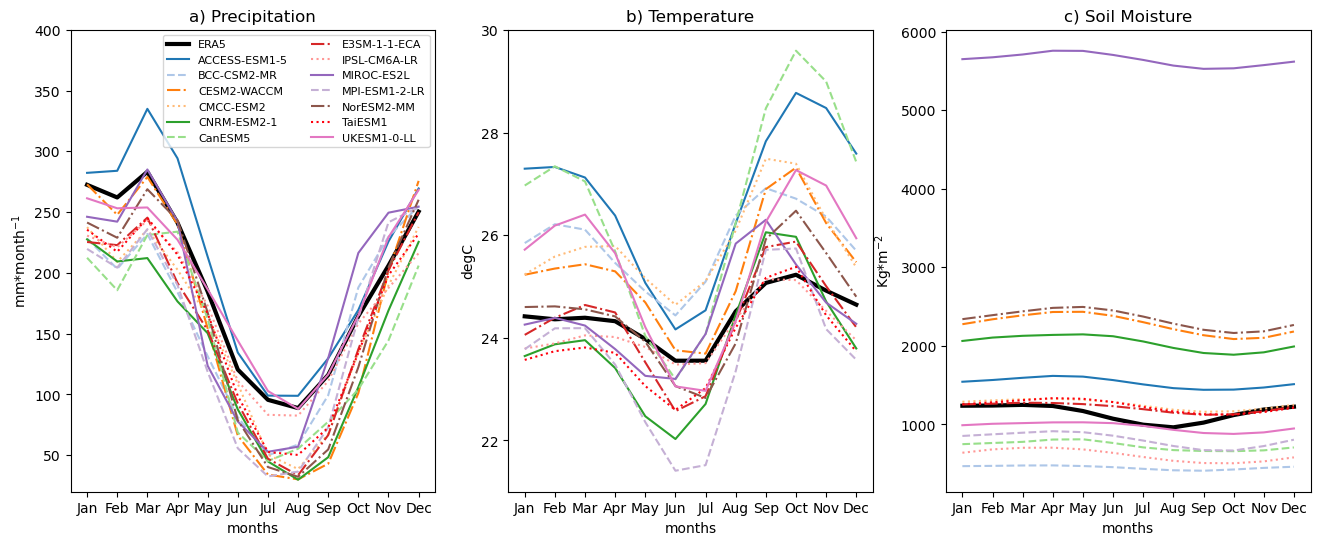

In [36]:
fig = plt.figure(figsize=(16, 6))

esm = sorted(list(set(files_list)))
esm.insert(0,"ERA5")
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ax = fig.add_subplot(131)
ax.plot(ds_pr_era5_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_pr_amz):
    ax.plot(months, item) 
ax.set_ylabel("mm*month$^{-1}$")
ax.set_xlabel("months")
ax.set_ylim(20,400)
ax.set_title("a) Precipitation")
ax.legend(esm, fontsize = 8, ncol=2, loc = "upper right")

ax = fig.add_subplot(132)
ax.plot(ds_tas_era5_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_tas_amz):
    ax.plot(months, item) 
ax.set_ylabel("degC")
ax.set_xlabel("months")
ax.set_title("b) Temperature")

ax = fig.add_subplot(133)
ax.plot(ds_mrso_era5_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_mrso_amz):
    ax.plot(months, item) 
ax.set_ylabel("Kg*m$^{-2}$")
ax.set_xlabel("months")
ax.set_title("c) Soil Moisture")

title = "Amazon seasonal cycle - ERA5"
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path + "/validation_" + title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

Energy Fluxes

In [38]:
# Compute multi-year monthly mean 
ds_le_flux_monmean = ds_le_flux.groupby('time.month').mean(dim = 'time')
ds_rn_flux_monmean = ds_rn_flux.groupby('time.month').mean(dim = 'time')

ds_le_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_le]
ds_rn_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_rn]

# Zonal mean of renalysis and ESM
def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_m.groupby("region").mean(...)
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

ds_le_flux_amz = zonal_stat(ds_le_flux_monmean, geodf).sel(region = 1)
ds_le_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_le_monmean]

ds_rn_flux_amz = zonal_stat(ds_rn_flux_monmean, geodf).sel(region = 1)
ds_rn_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_rn_monmean]

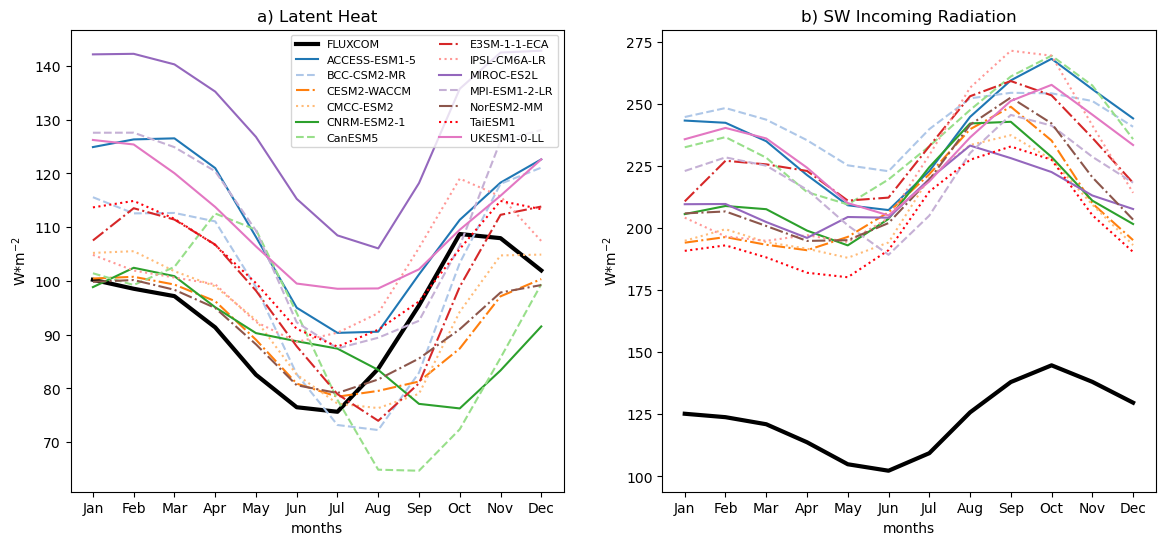

In [39]:
fig = plt.figure(figsize=(14, 6))

esm = sorted(list(set(files_list)))
esm.insert(0,"FLUXCOM")
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ax = fig.add_subplot(121)
ax.plot(ds_le_flux_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2'],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_le_amz):
    ax.plot(months, item) 
ax.set_ylabel("W*m$^{-2}$")
ax.set_xlabel("months")
ax.set_title("a) Latent Heat")
ax.legend(esm, fontsize = 8, ncol=2, loc = "upper right")

ax = fig.add_subplot(122)
ax.plot(ds_rn_flux_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_rn_amz):
    ax.plot(months, item) 
ax.set_ylabel("W*m$^{-2}$")
ax.set_xlabel("months")
ax.set_title("b) SW Incoming Radiation")


title = "Amazon seasonal cycle - FLUXCOM (Energy Fluxes)"
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path + "/validation_" + title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

Carbon Fluxes

In [40]:
# Compute multi-year monthly mean 
ds_nep_flux_monmean = ds_nep_flux.groupby('time.month').mean(dim = 'time')
ds_gpp_flux_monmean = ds_gpp_flux.groupby('time.month').mean(dim = 'time')
ds_ter_flux_monmean = ds_ter_flux.groupby('time.month').mean(dim = 'time')

ds_nep_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_nep]
ds_gpp_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_gpp]
ds_ter_monmean = [a.groupby('time.month').mean(dim = 'time') for a in ds_ter]

# Zonal mean of renalysis and ESM
def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_m.groupby("region").mean(...)
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

ds_nep_flux_amz = zonal_stat(ds_nep_flux_monmean, geodf).sel(region = 1)
ds_nep_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_nep_monmean]

ds_gpp_flux_amz = zonal_stat(ds_gpp_flux_monmean, geodf).sel(region = 1)
ds_gpp_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_gpp_monmean]

ds_ter_flux_amz = zonal_stat(ds_ter_flux_monmean, geodf).sel(region = 1)
ds_ter_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_ter_monmean]

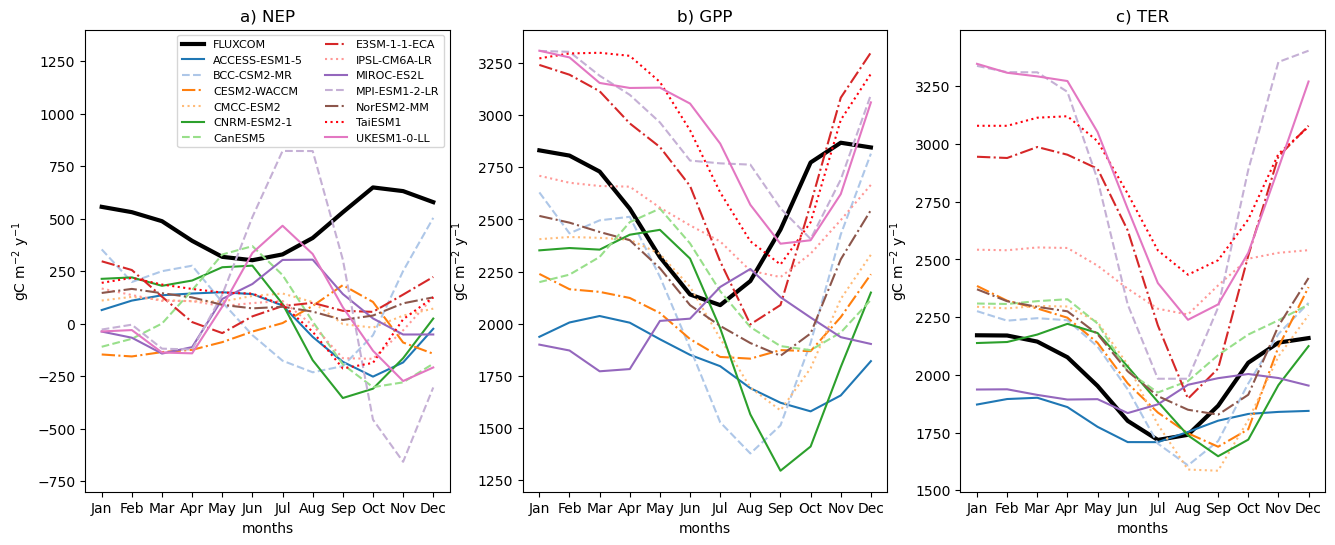

In [41]:
fig = plt.figure(figsize=(16, 6))

esm = sorted(list(set(files_list)))
esm.insert(0,"FLUXCOM")
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ax = fig.add_subplot(131)
ax.plot(ds_nep_flux_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_nep_amz):
    ax.plot(months, item) 
ax.set_ylim(-800, 1400)
ax.set_ylabel("gC m$^{-2}$ y$^{-1}$")
ax.set_xlabel("months")
ax.set_title("a) NEP")
ax.legend(esm, fontsize = 8, ncol=2, loc = "upper right")

ax = fig.add_subplot(132)
ax.plot(ds_gpp_flux_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_gpp_amz):
    ax.plot(months, item) 
ax.set_ylabel("gC m$^{-2}$ y$^{-1}$")
ax.set_xlabel("months")
ax.set_title("b) GPP")

ax = fig.add_subplot(133)
ax.plot(ds_ter_flux_amz, color = 'black', linewidth = 3)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
    '#e377c2' ],
                    linestyle = ["-","--","-.",":","-","--","-.",":","-","--","-.",":","-"])

for i, item in enumerate(ds_ter_amz):
    ax.plot(months, item) 
ax.set_ylabel("gC m$^{-2}$ y$^{-1}$")
ax.set_xlabel("months")
ax.set_title("c) TER")

title = "Amazon seasonal cycle - FLUXCOM (Carbon Fluxes)"
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path + "/validation_" + title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

## Boxplots

Carbon Fluxes

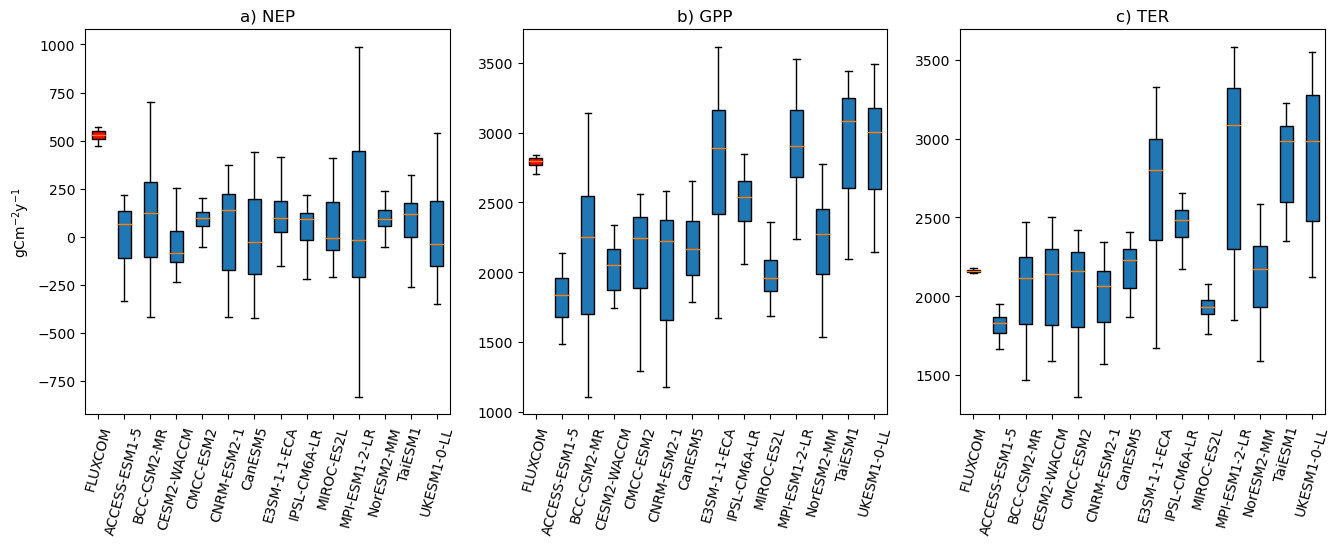

In [56]:
# ALL year

ds_nep_flux_amz = zonal_stat(ds_nep_flux, geodf).sel(region = 1)
ds_nep_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_nep]

ds_gpp_flux_amz = zonal_stat(ds_gpp_flux, geodf).sel(region = 1)
ds_gpp_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_gpp]

ds_ter_flux_amz = zonal_stat(ds_ter_flux, geodf).sel(region = 1)
ds_ter_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_ter]

# Append fluxcom data to ESM
ds_nep_boxplot = []
for i, item in enumerate(ds_nep_amz):
    content = xr.DataArray.copy(ds_nep_amz[i])
    ds_nep_boxplot.append(content)
ds_nep_boxplot.insert(0,ds_nep_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

ds_gpp_boxplot = []
for i, item in enumerate(ds_gpp_amz):
    content = xr.DataArray.copy(ds_gpp_amz[i])
    ds_gpp_boxplot.append(content)
ds_gpp_boxplot.insert(0,ds_gpp_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

ds_ter_boxplot = []
for i, item in enumerate(ds_ter_amz):
    content = xr.DataArray.copy(ds_ter_amz[i])
    ds_ter_boxplot.append(content)
ds_ter_boxplot.insert(0,ds_ter_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

# E3SM model has missing data for TER and GPP, replace nan with mean(1979/2014) so that not to influence distribution
ds_nep_flux_amz1 = []
for i,item in enumerate(ds_nep_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_nep_flux_amz1.append(item)

ds_gpp_flux_amz1 = []
for i,item in enumerate(ds_gpp_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_gpp_flux_amz1.append(item)

ds_ter_flux_amz1 = []
for i,item in enumerate(ds_ter_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_ter_flux_amz1.append(item)

fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(131)
bplot = ax.boxplot(ds_nep_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.set_xticklabels(data_list,rotation = 75)
ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
ax.set_title("a) NEP")

ax = fig.add_subplot(132)
bplot = ax.boxplot(ds_gpp_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.set_xticklabels(data_list,rotation = 75)
# ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
ax.set_title("b) GPP")

ax = fig.add_subplot(133)
bplot = ax.boxplot(ds_ter_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.set_xticklabels(data_list,rotation = 75)
# ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
ax.set_title("c) TER")

title = "Boxplot Amazon - FLUXCOM (Carbon Fluxes)"
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path + "/validation_" + title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13


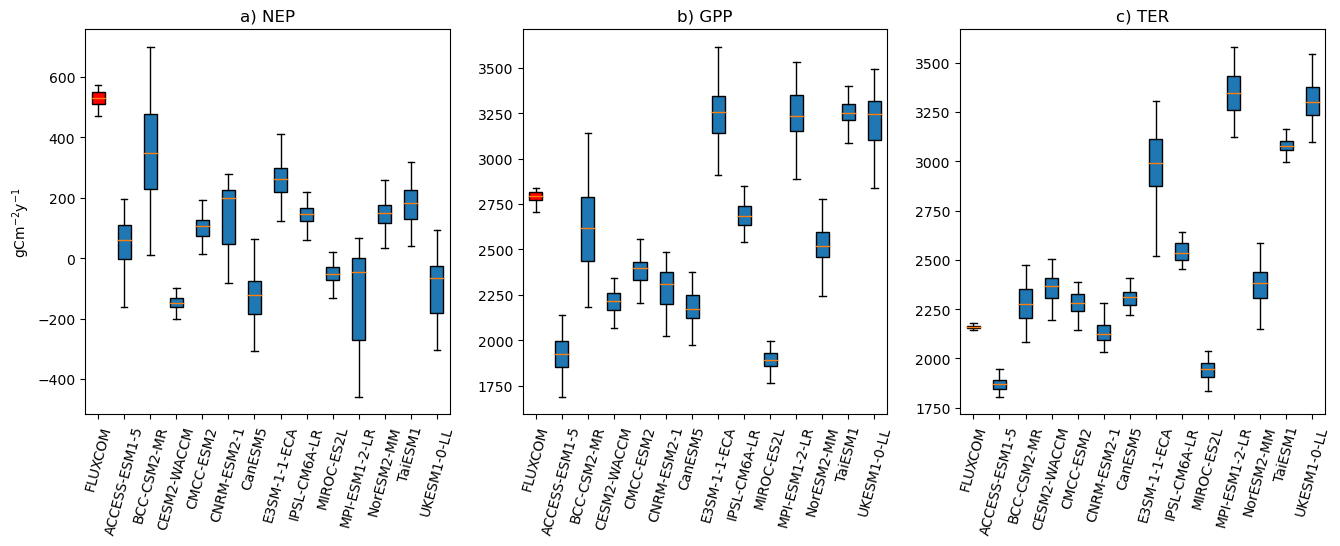

In [59]:
# DJF
ds_nep_flux= ds_nep_flux.resample(time="QS", label='left').mean(); ds_nep_flux= ds_nep_flux.sel(time = ds_nep_flux.time.dt.season=="DJF")
ds_gpp_flux= ds_gpp_flux.resample(time="QS", label='left').mean(); ds_gpp_flux= ds_gpp_flux.sel(time = ds_gpp_flux.time.dt.season=="DJF")
ds_ter_flux= ds_ter_flux.resample(time="QS", label='left').mean(); ds_ter_flux= ds_ter_flux.sel(time = ds_ter_flux.time.dt.season=="DJF")
ds_nep_amz= [a.resample(time="QS", label='left').mean() for a in ds_nep]; ds_nep_amz= [a.sel(time = a.time.dt.season=="DJF") for a in ds_nep]
ds_gpp_amz= [a.resample(time="QS", label='left').mean() for a in ds_gpp]; ds_gpp_amz= [a.sel(time = a.time.dt.season=="DJF") for a in ds_gpp]
ds_ter_amz= [a.resample(time="QS", label='left').mean() for a in ds_ter]; ds_ter_amz= [a.sel(time = a.time.dt.season=="DJF") for a in ds_ter]

ds_nep_flux_amz = zonal_stat(ds_nep_flux, geodf).sel(region = 1)
ds_nep_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_nep_amz]

ds_gpp_flux_amz = zonal_stat(ds_gpp_flux, geodf).sel(region = 1)
ds_gpp_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_gpp_amz]

ds_ter_flux_amz = zonal_stat(ds_ter_flux, geodf).sel(region = 1)
ds_ter_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_ter_amz]

# Append fluxcom data to ESM
ds_nep_boxplot = []
for i, item in enumerate(ds_nep_amz):
    content = xr.DataArray.copy(ds_nep_amz[i])
    ds_nep_boxplot.append(content)
ds_nep_boxplot.insert(0,ds_nep_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

ds_gpp_boxplot = []
for i, item in enumerate(ds_gpp_amz):
    content = xr.DataArray.copy(ds_gpp_amz[i])
    ds_gpp_boxplot.append(content)
ds_gpp_boxplot.insert(0,ds_gpp_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

ds_ter_boxplot = []
for i, item in enumerate(ds_ter_amz):
    content = xr.DataArray.copy(ds_ter_amz[i])
    ds_ter_boxplot.append(content)
ds_ter_boxplot.insert(0,ds_ter_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

# E3SM model has missing data for TER and GPP, replace nan with mean(1979/2014) so that not to influence distribution
ds_nep_flux_amz1 = []
for i,item in enumerate(ds_nep_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_nep_flux_amz1.append(item)

ds_gpp_flux_amz1 = []
for i,item in enumerate(ds_gpp_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_gpp_flux_amz1.append(item)

ds_ter_flux_amz1 = []
for i,item in enumerate(ds_ter_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_ter_flux_amz1.append(item)

fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(131)
bplot = ax.boxplot(ds_nep_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.set_xticklabels(data_list,rotation = 75)
ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
ax.set_title("a) NEP")

ax = fig.add_subplot(132)
bplot = ax.boxplot(ds_gpp_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.set_xticklabels(data_list,rotation = 75)
# ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
ax.set_title("b) GPP")

ax = fig.add_subplot(133)
bplot = ax.boxplot(ds_ter_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.set_xticklabels(data_list,rotation = 75)
# ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
ax.set_title("c) TER")

title = "Boxplot Amazon - FLUXCOM (Carbon Fluxes) - DJF"
# fig.suptitle(title, fontsize = 14)
# output_file = os.path.join(out_path + "/validation_" + title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
ds_nep_flux_amz1 = []
for i,item in enumerate(ds_nep_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_nep_flux_amz1.append(item)

In [58]:
ds_nep_flux_amz1

13

Energy Fluxes

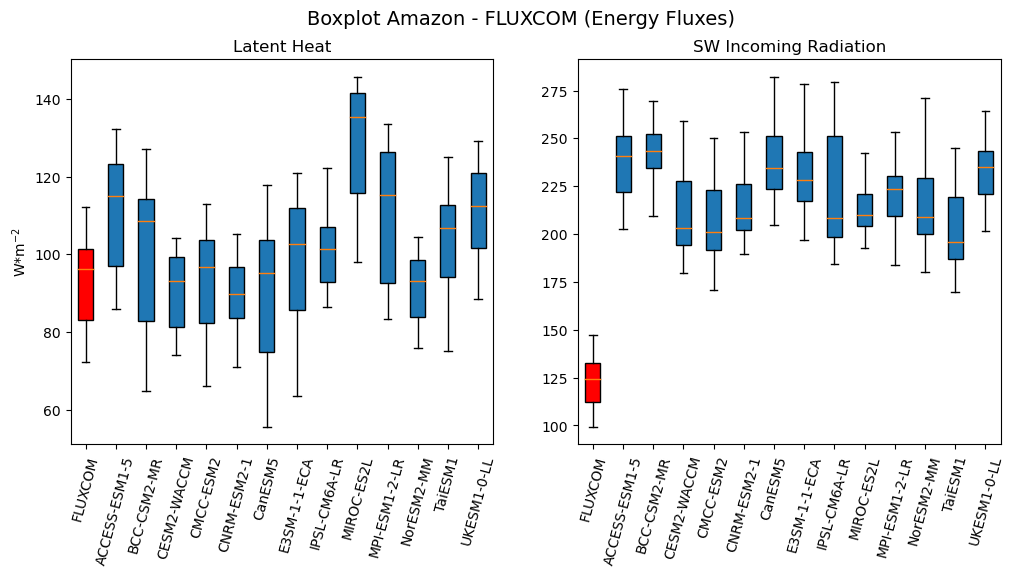

In [55]:
# ALL year
ds_le_flux_amz = zonal_stat(ds_le_flux, geodf).sel(region = 1)
ds_le_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_le]

ds_rn_flux_amz = zonal_stat(ds_rn_flux, geodf).sel(region = 1)
ds_rn_amz = [zonal_stat(a, geodf).sel(region = 1) for a in ds_rn]

# Append fluxcom data to ESM
ds_le_boxplot = []
for i, item in enumerate(ds_le_amz):
    content = xr.DataArray.copy(ds_le_amz[i])
    ds_le_boxplot.append(content)
ds_le_boxplot.insert(0,ds_le_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

ds_rn_boxplot = []
for i, item in enumerate(ds_rn_amz):
    content = xr.DataArray.copy(ds_rn_amz[i])
    ds_rn_boxplot.append(content)
ds_rn_boxplot.insert(0,ds_rn_flux_amz)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")


ds_le_flux_amz1 = []
for i,item in enumerate(ds_le_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_le_flux_amz1.append(item)

ds_rn_flux_amz1 = []
for i,item in enumerate(ds_rn_boxplot):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_rn_flux_amz1.append(item)


fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
bplot = ax.boxplot(ds_le_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.set_xticklabels(data_list,rotation = 75)
ax.set_ylabel("W*m$^{-2}$")
ax.set_title("Latent Heat")

ax = fig.add_subplot(122)
bplot = ax.boxplot(ds_rn_flux_amz1,
            vert=True,  # vertical box alignment
            patch_artist=True,
            sym = "",
            labels = data_list)  # fill with colorlabels =files_list)
colors = ['red']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.set_xticklabels(data_list,rotation = 75)
# ax.set_ylabel("gCm$^{-2}$y$^{-1}$")
# ax.set_ylabel("W*m$^{-2}$")
ax.set_title("SW Incoming Radiation")

title = "Boxplot Amazon - FLUXCOM (Energy Fluxes)"
fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path + "/validation_" + title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()


### Biases of SST

In [ ]:

# Cell area to compute spatial average
cell_ocean_area = [cell_weight(a) for a in ds_tos]

# Bias relative to tropical mean SST
bias_tos = []
bias_tos_rel = []
for i, item in enumerate(ds_tos):
    content = (item.sel(time = item.time.dt.season == seas).mean(dim = 'time') - ds_tos_rean.sel(time = ds_tos_rean.time.dt.season == seas).mean(dim = 'time')).compute()
    rel = content - content.sel(lat = slice(-30, 30)).weighted(cell_ocean_area[i]).mean()
    bias_tos.append(content)
    bias_tos_rel.append(rel)

cell_ocean_area = [cell_weight(a) for a in ds_tos]

# Bias in south eastern pacific
bias_tos_sepac = []
for i,item in enumerate(bias_tos_rel):
    content = bias_tos[i].sel(lat = slice(-20,0), lon = slice(250,290))
    content1 = content.fillna(content.mean(["lat","lon"]))
    content1 = content1.weighted(cell_ocean_area[i]).mean(["lat","lon"],skipna = True)#.sel(time = bias_pr[i].time.dt.season == seas)
    bias_tos_sepac.append(content1)

# Bias in tropical south atlantic
bias_tos_tsa = []
for i,item in enumerate(bias_tos_rel):
    content = bias_tos[i].sel(lat = slice(-20,0), lon = slice(330,360))
    content1 = content.fillna(content.mean(["lat","lon"]))
    content1 = content1.weighted(cell_ocean_area[i]).mean(["lat","lon"],skipna = True)#.sel(time = bias_pr[i].time.dt.season == seas)
    bias_tos_tsa.append(content1)

# Bias in tropical north atlantic
bias_tos_tna = []
for i,item in enumerate(bias_tos_rel):
    content = bias_tos[i].sel(lat = slice(5,25), lon = slice(305,345))
    content1 = content.fillna(content.mean(["lat","lon"]))
    content1 = content1.weighted(cell_ocean_area[i]).mean(["lat","lon"],skipna = True)#.sel(time = bias_pr[i].time.dt.season == seas)  
    bias_tos_tna.append(content1)

# Bias in nino3.4 region
bias_tos_enso = []
for i,item in enumerate(bias_tos_rel):
    content = bias_tos[i].sel(lat = slice(-5,5), lon = slice(180,240))
    content1 = content.fillna(content.mean(["lat","lon"]))
    content1 = content1.weighted(cell_ocean_area[i]).mean(["lat","lon"],skipna = True)#.sel(time = bias_pr[i].time.dt.season == seas)
    bias_tos_enso.append(content1)

bias_tos_sepac = xr.concat(bias_tos_sepac, dim = "esm")
bias_tos_tsa = xr.concat(bias_tos_tsa, dim = "esm")
bias_tos_tna = xr.concat(bias_tos_tna, dim = "esm")
bias_tos_enso = xr.concat(bias_tos_enso, dim = "esm")

In [ ]:
# Convert to pandas dataframe

df_bias_tos_sepac = bias_tos_sepac.to_dataframe(name="se_pac"); df_bias_tos_sepac = df_bias_tos_sepac.rename(index=dict(zip(df_bias_tos_sepac.index, files_list)))
df_bias_tos_enso = bias_tos_enso.to_dataframe(name="enso"); df_bias_tos_enso = df_bias_tos_enso.rename(index=dict(zip(df_bias_tos_enso.index, files_list)))
df_bias_tos_tsa = bias_tos_tsa.to_dataframe(name="tsa"); df_bias_tos_tsa = df_bias_tos_tsa.rename(index=dict(zip(df_bias_tos_tsa.index, files_list)))
df_bias_tos_tna = bias_tos_tna.to_dataframe(name="tna"); df_bias_tos_tna = df_bias_tos_tna.rename(index=dict(zip(df_bias_tos_tna.index, files_list)))


## Unite ESM and ERA5 

In [ ]:
# Append fluxcom data to ESM

DS_data = []
for i, item in enumerate(DS_models):
    content = xr.DataArray.copy(DS_models[i])
    DS_data.append(content)
DS_data.insert(0,DS_obs)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

# DS_Data statistics

DS_data_ymean = [(a.mean(dim = 'time')) for a in DS_data]
DS_data_seasmean = [(a.sel(time = a.time.dt.season == seas).mean(dim = "time")) for a in DS_data]
DS_data_monmean = [(a.groupby('time.month').mean(dim = 'time')) for a in DS_data]


### Plot Models

In [ ]:
#### ------- MULTIMODEL PLOT -------- ####
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

data_plot = DS_data_seasmean

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_position = "top"
                                                     
# --- Title & Axes labels
if var_name == 'pr':
    title = 'precipitation' + " - " +"1980/2010 DJF Mean"
    cmap = "RdBu"
    cbar_label = "mmy$^{-1}$"
elif var_name == 'mrso':
    title = 'soil moisture' + " - " +"1980/2010 DJF Mean"
    cmap = "BrBG"
    cbar_label = "Kgm$^{-2}$"
elif var_name == 'tas':
    title = 'temperature' + " - " +"1980/2010 DJF Mean"
    cmap = "RdYlBu_r"
    cbar_label = "degC"

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 22 : 2 * i -20], projection = ccrs.PlateCarree())

    lons = data_plot[i].lon
    lats = data_plot[i].lat

    if var_name == "mrso":
        min_value, max_value = 0, 6000                              # Soil Moisture

    map = ax.contourf(lons, lats, data_plot[i], transform = ccrs.PlateCarree(), cmap=cmap,  norm=colors.TwoSlopeNorm(0))   ## -- use colors.TwoSlopeNorm(0) for asymmetrical values colormaps
    
    ax.set_extent([lon_min, lon_max, lat_min+2, lat_max])
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))

    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    #ax.set_ylabel(ylabel, **ylabel_fontstyle)
    
    # from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    # gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),x_inline=False, y_inline=False,linewidth=0, 
    #                         xlocs=[-80,-60, -40],
    #                         ylocs=[-20,-10,0,10])
    # gl.right_labels = False
    # gl.top_labels = False
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER

    ax.tick_params(axis='both', labelsize=10) 
    ax.label_outer()
    ax.set_title(data_list[i],fontsize=12)  

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
#fig.tight_layout()
cbar_ax = fig.add_axes([0.8, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map, cax=cbar_ax, extend="both")
clb.cmap.set_under('maroon')
clb.cmap.set_over('darkslategray')

clb.set_label(cbar_label)
#clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Set plot properties
fig.suptitle(title, fontsize = 20, y=1.05)
#fig.supylabel(ylabel)

# --- Output file
output_file = os.path.join(out_path,"validation_MM_" + title.replace('/','_')) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### Plot BIAS

In [ ]:
#### ------- MULTIMODEL PLOT -------- ####
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

data_plot = bias_seasmean

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_position = "top"
                                                     
# --- Title & Axes labels
if var_name == 'pr':
    title = 'Bias precipitation' + " - " +"1980/2010 DJF Mean"
    cbar_label = "mmy$^{-1}$"
    cmap = "RdBu"
elif var_name == 'mrso':
    title = 'Bias soil moisture' + " - " +"1980/2010 DJF Mean"
    cbar_label = "Kgm$^{-2}$"
    cmap = "BrBG"  
elif var_name == 'tas':
    title = 'Bias temperature' + " - " +"1980/2010 DJF Mean"
    cbar_label = "degC"
    cmap = "RdYlBu_r"

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    lons = data_plot[i].lon
    lats = data_plot[i].lat

    if var_name == "pr":
        min_value, max_value, bins_value = -800, 800, 20              # Precipitation
        v = np.linspace(min_value, max_value, bins_value, endpoint=True)

    if var_name == "tas":
        min_value, max_value, bins_value = -6, +6, 20              # Temperature
        v = np.linspace(min_value, max_value, bins_value, endpoint=True)
    
    if var_name == "mrso":
        min_value, max_value, bins_value = -1000, +1000, 10              # Soil Moisture
        v = np.linspace(min_value, max_value, bins_value, endpoint=True)

    map = ax.contourf(lons, lats, data_plot[i], v, transform = ccrs.PlateCarree(), cmap=cmap, extend="both")
    # map = ax.contourf(lons, lats, data_plot[i], transform = ccrs.PlateCarree(), cmap=cmap)   ## -- use norm=colors.TwoSlopeNorm(0) for asymmetrical values colormaps

    ax.set_extent([lon_min, lon_max, lat_min+2, lat_max])
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))

    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    #ax.set_ylabel(ylabel, **ylabel_fontstyle)

    ax.tick_params(axis='both', labelsize=10) 
    ax.label_outer()
    ax.set_title(data_plot[i].esm.values,fontsize=12)  

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
#fig.tight_layout()
cbar_ax = fig.add_axes([0.8, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map, cax=cbar_ax, extend="both")
clb.cmap.set_under()
clb.cmap.set_over()

clb.set_label(cbar_label)
clb.ax.set_yticklabels(np.int64(np.arange(min_value,max_value,(max_value-min_value)/bins_value)))

# --- Set plot properties
fig.suptitle(title, fontsize = 20, y=1.05)
#fig.supylabel(ylabel)

# --- Output file
output_file = os.path.join(out_path,"validation_MM_" + title.replace('/','_')) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### Plot Reanalysis

In [ ]:
#### ------- REANALYSIS PLOT -------- ####
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

data_plot = DS_obs_seasmean

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 6

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_label = 'mm'                                        # Hydro: 'mm' mrso:'Kgm$^{-2}$' tas&tos:"degC"  Carbon:'gCm$^{-2}$y$^{-1}$'abs 
cbar_position = "top"
#cmap = "BrBG"                                                       # mrso:"BrBG", pr:"RdBu", tas:"YlOrRd" Carbon:"RdYlGn"abs, ts:"coolwarm"

# --- Title & Axes labels
if var_name == 'pr':
    title = 'ERA5 Precipitation' + " - " +"1980/2010 DJF Mean"; cmap = "YlGnBu"; cbar_label = 'mm'

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'
#title = ' - '.join((var_str, time_period))

title_fontstyle = {
    "fontsize": "20",
 #   "fontstyle": "italic",
 #   "fontweight": "bold",
    "pad": 30
}

xlabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 30
}

ylabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 20
}

cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 5
}

# Create the figure 
#ax = plt.axes(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) #, constrained_layout=True)

lons = data_plot.lon
lats = data_plot.lat

min_value, max_value, bins_value = 0, 1500, 20              # Precipitation
v = np.linspace(min_value, max_value, bins_value, endpoint=True)

map = plt.contourf(lons, lats, data_plot, v, cmap=cmap, transform = ccrs.PlateCarree(), extend="max")#, norm=colors.TwoSlopeNorm(0))             ## -- don't use colors.TwoSlopeNorm(0) for tas

ax.set_extent([lon_min, lon_max, lat_min+2, lat_max])
ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))

# Longitude labels
ax.set_xticks(np.arange(lon_min,lon_max,15), crs=ccrs.PlateCarree())
lon_formatter = LONGITUDE_FORMATTER
ax.xaxis.set_major_formatter(lon_formatter)
#axs.set_xlabel(xlabel, **xlabel_fontstyle)

# Latitude labels
ax.set_yticks(np.arange(lat_min,lat_max+1,10), crs=ccrs.PlateCarree())
lat_formatter = LATITUDE_FORMATTER
ax.yaxis.set_major_formatter(lat_formatter)
#axs.set_ylabel(ylabel, **ylabel_fontstyle)

ax.tick_params(axis='both', labelsize=12 ) 

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
#fig.tight_layout()
cbar_ax = fig.add_axes([0.75, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height

clb = fig.colorbar(map, cax=cbar_ax, extend="max")
clb.cmap.set_over()

clb.set_label(cbar_label, **cbar_fontstyle)
clb.ax.set_yticklabels(np.int64(np.arange(min_value,max_value,max_value/bins_value)))

# --- Set plot properties
fig.suptitle(title, fontsize = 20, y=1.05)
#fig.supylabel(ylabel)

# --- Output file
output_file = os.path.join(out_path,"validation_" + title.replace('/','_')) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Temperature

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'               ## MAC OS
scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '*_1x1_val.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):               # List of files sorted by name
        content = nc.Dataset(filepath).parent_source_id
        files_list.append(content)   

ds_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_tas.append(content)

# Coordinates LONGITUDE [275 330]; LATITUDE [-30 14] 

if var_name == "tas":
    for i, item in enumerate(ds_tas):
        if ds_tas[i].lat[0] == -34.5:
            #ds_tas[i] = ds_tas[i].roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
            ds_tas[i] = ds_tas[i].assign_coords(lat=(ds_tas[i].lat - 0.5))

ds_tas = [a.sel(lat=slice(-30,14),lon = slice(270,330)) for a in ds_tas]

In [ ]:
# Precipitation

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'               ## MAC OS
scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '*_1x1_val.nc' 

ds_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_pr.append(content)

# Coordinates LONGITUDE [275 330]; LATITUDE [-30 14] 

for i, item in enumerate(ds_pr):
    if ds_pr[i].lat[0] == -34.5:
        #ds_pr[i] = ds_pr[i].roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
        ds_pr[i] = ds_pr[i].assign_coords(lat=(ds_pr[i].lat - 0.5))

ds_pr = [a.sel(lat=slice(-30,14),lon = slice(270,330)) for a in ds_pr]

In [ ]:
# Soil Moisture

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'               ## MAC OS
scenario = 'historical'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '*_1x1_val.nc' 

ds_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_mrso.append(content)

# Coordinates LONGITUDE [275 330]; LATITUDE [-30 14] 

for i, item in enumerate(ds_mrso):
    if ds_mrso[i].lat[0] == -34.5:
        #ds_mrso[i] = ds_mrso[i].roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
        ds_mrso[i] = ds_mrso[i].assign_coords(lat=(ds_mrso[i].lat - 0.5))

ds_mrso = [a.sel(lat=slice(-30,14),lon = slice(270,330)) for a in ds_mrso]

In [ ]:
# SST

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'               ## MAC OS
scenario = 'historical'
var_name = 'tos'
files = var_name + '_*_' + scenario + '*_1x1_val.nc' 

ds_tos = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_tos.append(content)


In [ ]:
# NEP

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'
scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '*_1x1_val.nc' 

ds_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_nep.append(content)

## -- Correct E3SM dataarray by masking values of 1e+20 over ocean
for i, item in enumerate(files_list):
    if files_list[i] == 'E3SM-1-1-ECA' and var_name == "nep":
        ds_nep[i] = ds_nep[i].where((ds_nep[i]< 5000)&(ds_nep[i]> -5000))   
    elif files_list[i] == 'E3SM-1-1-ECA' and (var_name == "ter" or var_name =="gpp"):
        ds_nep[i] = ds_nep[i].where((ds_nep[i]< 10000))   


In [ ]:
# GPP

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'
scenario = 'historical'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '*_1x1_val.nc' 

ds_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_gpp.append(content)

## -- Correct E3SM dataarray by masking values of 1e+20 over ocean
for i, item in enumerate(files_list):
    if files_list[i] == 'E3SM-1-1-ECA' and var_name == "nep":
        ds_gpp[i] = ds_gpp[i].where((ds_gpp[i]< 5000)&(ds_gpp[i]> -5000))   
    elif files_list[i] == 'E3SM-1-1-ECA' and (var_name == "ter" or var_name =="gpp"):
        ds_gpp[i] = ds_gpp[i].where((ds_gpp[i]< 10000))   


In [ ]:
# TER

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'
scenario = 'historical'
var_name = 'ter'
files = var_name + '_*_' + scenario + '*_1x1_val.nc'

ds_ter = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_ter.append(content)

## -- Correct E3SM dataarray by masking values of 1e+20 over ocean
for i, item in enumerate(files_list):
    if files_list[i] == 'E3SM-1-1-ECA' and var_name == "nep":
        ds_ter[i] = ds_ter[i].where((ds_ter[i]< 5000)&(ds_ter[i]> -5000))   
    elif files_list[i] == 'E3SM-1-1-ECA' and (var_name == "ter" or var_name =="gpp"):
        ds_ter[i] = ds_ter[i].where((ds_ter[i]< 10000))   


In [ ]:
# REANALYSIS

data_path = 'C:/Users/mastr/Documents/Amazon/validation/'

ds_tas_rean = xr.open_dataarray(os.path.join(data_path+'tas_era5_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
ds_pr_rean = xr.open_dataarray(os.path.join(data_path+'pr_era5_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
ds_mrso_rean = xr.open_dataarray(os.path.join(data_path+'mrso_era5_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
ds_nep_rean = xr.open_dataarray(os.path.join(data_path+'nep_fluxcom_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
ds_gpp_rean = xr.open_dataarray(os.path.join(data_path+'gpp_fluxcom_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
ds_ter_rean = xr.open_dataarray(os.path.join(data_path+'ter_fluxcom_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
ds_tos_rean = xr.open_dataarray(os.path.join(data_path+'tos_hadsst_1x1_val.nc'), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)

#DS_obs = DS_obs.rename({"longitude":"lon"}); DS_obs = DS_obs.rename({"latitude":"lat"})
#DS_obs = DS_obs.roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
#DS_obs = DS_obs.reindex(lat=DS_obs.lat[::-1])                                   # Invert latitude to -89.5 89.5

# Replace -1000 (sea ice) with nan and format coords
ds_tos_rean = ds_tos_rean.where(ds_tos_rean != -1000.)  
ds_tos_rean = ds_tos_rean.rename({"longitude":"lon"}); ds_tos_rean = ds_tos_rean.rename({"latitude":"lat"})
ds_tos_rean = ds_tos_rean.assign_coords(lon=(ds_tos_rean.lon - 0.5)); 

# Temperature from Kelvin to Celsius
ds_tas_rean = ds_tas_rean-273.15
# NEP from upward to downward
ds_nep_rean = ds_nep_rean*-1

In [ ]:
# Mean response of ESM realizations

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

ds_tas = xr_mean_list(ds_tas, files_list)
ds_pr = xr_mean_list(ds_pr, files_list)
ds_mrso = xr_mean_list(ds_mrso, files_list)
ds_nep = xr_mean_list(ds_nep, files_list)
ds_gpp = xr_mean_list(ds_gpp, files_list)
ds_ter = xr_mean_list(ds_ter, files_list)
ds_tos = xr_mean_list(ds_tos, files_list)


## Scatterplot of GPP/NEP/TER vs pr/tas

Is there a relationship between carbon fluxes in the Amazon basin and climatological variables?

In [ ]:
seas = "DJF"

geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
#geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [ ]:
# Zonal mean in Amazon Basin

# DJF zonal mean calculation
ds_ter_amz = [(zonal_stat(a, geodf).sel(region = 4)) for a in ds_ter] #a.sel(time = a.time.dt.season == seas)
ds_tas_amz = [(zonal_stat(a, geodf).sel(region = 4)) for a in ds_tas]
ds_pr_amz = [(zonal_stat(a, geodf).sel(region = 4)) for a in ds_pr]
ds_nep_amz = [(zonal_stat(a, geodf).sel(region = 4)) for a in ds_nep]
ds_mrso_amz = [(zonal_stat(a, geodf).sel(region = 4)) for a in ds_mrso]
ds_gpp_amz = [(zonal_stat(a, geodf).sel(region = 4)) for a in ds_gpp]


ds_ter_amz1 = []
for i,item in enumerate(ds_ter_amz):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_ter_amz1.append(item)

ds_tas_amz1 = []
for i,item in enumerate(ds_tas_amz):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_tas_amz1.append(item)

ds_pr_amz1 = []
for i,item in enumerate(ds_pr_amz):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_pr_amz1.append(item)

ds_nep_amz1 = []
for i,item in enumerate(ds_nep_amz):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_nep_amz1.append(item)

ds_mrso_amz1 = []
for i,item in enumerate(ds_mrso_amz):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_mrso_amz1.append(item)

ds_gpp_amz1 = []
for i,item in enumerate(ds_gpp_amz):
    if np.isnan(item).any() == True:     ##if nans replace with np.mean() 
        item[np.isnan(item)] = np.mean(item)
    ds_gpp_amz1.append(item)

In [ ]:
df_nep_amz = xr.concat(ds_nep_amz1, dim = "esm").to_dataframe(); df_nep_amz = df_nep_amz.drop(columns = "region").rename(index=dict(zip(df_nep_amz.index, files_list)))


In [ ]:
# Convert to pandas dataframe

import pandas as pd

df_gpp_amz = xr.concat(ds_gpp_amz1, dim = "esm").to_dataframe(); df_gpp_amz = df_gpp_amz.drop(columns = "region").rename(index=dict(zip(df_gpp_amz.index, files_list)))
df_ter_amz = xr.concat(ds_ter_amz1, dim = "esm").to_dataframe(); df_ter_amz = df_ter_amz.drop(columns = "region").rename(index=dict(zip(df_ter_amz.index, files_list)))
df_nep_amz = xr.concat(ds_nep_amz1, dim = "esm").to_dataframe(); df_nep_amz = df_nep_amz.drop(columns = "region").rename(index=dict(zip(df_nep_amz.index, files_list)))

# Not all ESM datasets have  height coordinate, thus use coords='minimal', compat='override'
df_tas_amz = xr.concat(ds_tas_amz1, dim = "esm", coords='minimal', compat='override').to_dataframe(); df_tas_amz = df_tas_amz.drop(columns = ["region", "height"]).rename(index=dict(zip(df_tas_amz.index, files_list)))
df_pr_amz = xr.concat(ds_pr_amz1, dim = "esm").to_dataframe(); df_pr_amz = df_pr_amz.drop(columns = "region").rename(index=dict(zip(df_pr_amz.index, files_list)))
df_mrso_amz = xr.concat(ds_mrso_amz1, dim = "esm").to_dataframe(); df_mrso_amz = df_mrso_amz.drop(columns = "region").rename(index=dict(zip(df_mrso_amz.index, files_list)))

df_amz = pd.concat([df_gpp_amz, df_ter_amz, df_nep_amz, df_tas_amz, df_pr_amz, df_mrso_amz], axis = 1)

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot('ter', 'tas', data=df_amz, hue=df_amz.index)
ax = sns.regplot(x='ter', y='tas', data=df_amz, scatter=False, line_kws={"color": "black"})

ax.set(xlabel='TER (gCm$^{-2}$y$^{-1}$)', ylabel='temperature (degC)')

plt.legend(loc='upper right', ncol=2, fontsize = 8)
plt.show()
title = "scatter tas TER"
output_file = os.path.join(out_path,"validation_" + title.replace('/','_')) + ".png"
fig.savefig(output_file, bbox_inches='tight')

ax = sns.scatterplot('ter', 'pr', data=df_amz, hue=df_amz.index)
ax.set(xlabel='TER (gCm$^{-2}$y$^{-1}$)', ylabel='precipitation (mm)')

plt.legend(loc='lower left', fontsize = 8)
plt.show()
